In [1]:
%matplotlib inline
import os
from tqdm import tqdm
import sys
import os
file_path = os.getcwd()
project_root = os.path.dirname(os.path.dirname(file_path))
import time
import jax
from jax import lax
from jax import flatten_util
from jax import vmap
import jax.numpy as jnp
import jaxopt
import optax
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from jax import jvp, vjp, value_and_grad
from flax import linen as nn
from typing import Sequence
from functools import partial
import scipy
from pyDOE import lhs
import scipy.io as sio

import jax
import jax.numpy as jnp
import jaxopt
from jaxopt import LBFGS
import random
import matplotlib as mpl


In [2]:
from jax import config
config.update("jax_default_matmul_precision", "float32")

In [3]:
cmap = 'RdBu_r'
num_colors=8
# Create a colormap
cmap = plt.get_cmap(cmap)
colors = [cmap(i) for i in np.linspace(0, 1, num_colors)]
colors=colors[:num_colors//4]+colors[3*num_colors//4:]
print(len(colors))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14

4


In [4]:
import tensorflow as tf
import argparse
# Set up argument parser
parser = argparse.ArgumentParser(description='Tuning Parameters')
parser.add_argument('--Equation', type=str, default='Allen_Cahn_light', help='Name of equation')
parser.add_argument('--Name', type=str, default='KART_all_', help='Name of the experiment')
parser.add_argument('--NC', type=int, default=25600, help='Number of samples for training')
parser.add_argument('--NI', type=int, default=512, help='Number of iterations')
parser.add_argument('--NB', type=int, default=512, help='Batch size')
parser.add_argument('--NC_TEST', type=int, default=100, help='Number of test samples')
parser.add_argument('--SEED', type=int, default=444, help='Random seed')
parser.add_argument('--EPOCHS', type=int, default=300000, help='Number of training epochs')
parser.add_argument('--N_LAYERS', type=int, default=4, help='Number of layers in the network')
parser.add_argument('--HIDDEN', type=int, default=32, help='Number of hidden units per layer')
parser.add_argument('--FEATURES', type=int, default=64, help='Feature size')
parser.add_argument('--degree', type=int, default=9, help='Degree of outer')
parser.add_argument('--degree_T', type=int, default=2, help='Degree of polynomial')
parser.add_argument('--lr_fact', type=float, default=0.2, help='Scale Lr')
parser.add_argument('--eta', type=float, default=0.01, help='Learning rate or step size for adaptive gamma')
parser.add_argument('--gamma', type=float, default=0.999, help='Decay rate for adaptive gamma')
parser.add_argument('--gamma_grads', type=float, default=0.99, help='Decay rate for adaptive gamma')
parser.add_argument('--alpha', type=float, default=1.0, help='Decay rate for exponential moving average')
parser.add_argument('--cap_RBA', type=float, default=20, help='Cap limit for RBA')
parser.add_argument('--max_RBA', type=float, help='Maximum RBA value, default calculated as eta / (1 - gamma)')
parser.add_argument('--decay_rate', type=float, default=0.9, help='Decay rate for learning rate schedule')
parser.add_argument('--LR', type=float, default=1e-3, help='Initial learning rate')
parser.add_argument('--decay_step', type=int,default=5000, help='Decay step size')
parser.add_argument('--Note', type=str, default='', help='In case')
parser.add_argument('--batch_size', type=int, default=10000, help='batch_size')
parser.add_argument('--k_samp', type=float, default=2.0, help='Enhance outliers smoothing factor')
parser.add_argument('--c_samp', type=float, default=0.5, help='homogenize')


# Parse arguments and display them
args, unknown = parser.parse_known_args()
for arg, value in vars(args).items():
    print(f'{arg}: {value}')

# Initialize parameters with parsed or default values
NC = args.NC
NI = args.NI
NB = args.NB
NC_TEST = args.NC_TEST
SEED = args.SEED
EPOCHS = args.EPOCHS
N_LAYERS = args.N_LAYERS
HIDDEN = args.HIDDEN
FEATURES = args.FEATURES
degree = args.degree
degree_T = args.degree_T
eta = args.eta
#RBA Params
gamma = args.gamma
alpha = args.alpha
max_RBA0 = args.max_RBA if args.max_RBA is not None else eta / (1 - gamma)
cap_RBA = args.cap_RBA
# Global weights
gamma_grads=args.gamma_grads
#RBA-R
k_samp=args.k_samp
c_samp=args.c_samp
batch_size=args.batch_size
# Optimizer parameters
decay_rate = args.decay_rate
LR = args.LR
lr0 = LR
decay_step = args.decay_step# if args.decay_step is not None else int(EPOCHS * jnp.log(decay_rate) / jnp.log(lrf / lr0))
args.Name=args.Name+f'RBA[{max_RBA0:.2f}-{cap_RBA:.2f}]_psi[N:{N_LAYERS},H:{HIDDEN},T:{degree_T},F:{FEATURES},lr:{lr0:.1e},rate:{decay_rate},step:{decay_step}]_g[d:{degree},lr:{args.lr_fact}]_GW:[{alpha:.6f},{args.gamma_grads:.4f}]_Seed:{SEED}-bs{batch_size}_k-s:{k_samp:.2f}{c_samp:.2f}'+args.Note
print(args.Name)
# random key
key = jax.random.PRNGKey(SEED)
key, subkey = jax.random.split(key, 2)
# Initialize NumPy seed
np.random.seed(SEED)
# Initialize Python's random module seed
random.seed(SEED)


2025-01-16 12:38:50.351913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737049130.391260 2395944 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737049130.401269 2395944 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Equation: Allen_Cahn_light
Name: KART_all_
NC: 25600
NI: 512
NB: 512
NC_TEST: 100
SEED: 444
EPOCHS: 300000
N_LAYERS: 4
HIDDEN: 32
FEATURES: 64
degree: 9
degree_T: 2
lr_fact: 0.2
eta: 0.01
gamma: 0.999
gamma_grads: 0.99
alpha: 1.0
cap_RBA: 20
max_RBA: None
decay_rate: 0.9
LR: 0.001
decay_step: 5000
Note: 
batch_size: 10000
k_samp: 2.0
c_samp: 0.5
KART_all_RBA[10.00-20.00]_psi[N:4,H:32,T:2,F:64,lr:1.0e-03,rate:0.9,step:5000]_g[d:9,lr:0.2]_GW:[1.000000,0.9900]_Seed:444-bs10000_k-s:2.000.50


2025-01-16 12:38:54.939802: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
args.Name =project_root+'/Results/'+args.Equation+'/'+args.Name+'/'
log_dir =args.Name  # specify the directory where logs will be saved
writer = tf.summary.create_file_writer(log_dir)
print(log_dir)

/oscar/data/gk/jdtoscan/PIML/Crunch_PIML/Results/Allen_Cahn_light/KART_all_RBA[10.00-20.00]_psi[N:4,H:32,T:2,F:64,lr:1.0e-03,rate:0.9,step:5000]_g[d:9,lr:0.2]_GW:[1.000000,0.9900]_Seed:444-bs10000_k-s:2.000.50/


I0000 00:00:1737049135.460668 2395944 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4236 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:25:00.0, compute capability: 8.6


# Auxiliary Functions

In [6]:
class WN_layer(nn.Module):
    out_features: int  # Number of output features
    kernel_init: nn.initializers.Initializer  # Custom initializer for W
    def setup(self):
        # Define bias and scale parameters; W will be initialized later
        self.b = self.param('b', nn.initializers.zeros, (self.out_features,))
        self.g = self.param('g', nn.initializers.ones, (self.out_features,))
    @nn.compact
    def __call__(self, H):
        # Determine input size from H dynamically
        in_features = H.shape[-1]
        # Initialize W with the specified kernel initializer and dynamic shape
        W = self.param('W', self.kernel_init, (in_features, self.out_features))
        # Weight normalization
        V = W / jnp.linalg.norm(W, axis=0, keepdims=True)
        return self.g * jnp.dot(H, V) + self.b

In [7]:
# Chebyshev's Polynomials
def T0(x):
    return x*0+1
def T1(x):
    return x
def T2(x):
    return 2*x**2-1
def T3(x):
    return 4*x**3-3*x
def T4(x):
    return 8*x**4-8*x**2+1
def T5(x):
    return 16*x**5-20*x**3+5*x
def T6(x):
    return 32*x**6-48*x**4+18*x**2-1
def T7(x):
    return 64*x**7-112*x**5+56*x**3-7*x
def T8(x):
    return 128*x**8-256*x**6+160*x**4-32*x**2+1
def T9(x):
    return 256*x**9-576*x**7+432*x**5-120*x**3+9*x
def T10(x):
    return 512*x**10-1280*x**8+1120*x**6-400*x**4+50*x**2-1
def T11(x):
    return 1024*x**11-2816*x**9+2816*x**7-1232*x**5+220*x**3-11*x
def T12(x):
    return 2048*x**12-6144*x**10+6912*x**8-3584*x**6+840*x**4-72*x**2+1
def T13(x):
    return x * (4096 * x**12 - 13312 * x**10 + 16640 * x**8 - 9984 * x**6 + 2912 * x**4 - 364 * x**2 + 13)

def T14(x):
    return 8192 * x**14 - 28672 * x**12 + 39424 * x**10 - 26880 * x**8 + 9408 * x**6 - 1568 * x**4 + 98 * x**2 - 1

def T15(x):
    return x * (16384 * x**14 - 61440 * x**12 + 92160 * x**10 - 70400 * x**8 + 28800 * x**6 - 6048 * x**4 + 560 * x**2 - 15)

def T16(x):
    return 32768 * x**16 - 131072 * x**14 + 212992 * x**12 - 180224 * x**10 + 84480 * x**8 - 21504 * x**6 + 2688 * x**4 - 128 * x**2 + 1

def T17(x):
    return x * (65536 * x**16 - 278528 * x**14 + 487424 * x**12 - 452608 * x**10 + 239360 * x**8 - 71808 * x**6 + 11424 * x**4 - 816 * x**2 + 17)

def T18(x):
    return 131072 * x**18 - 589824 * x**16 + 1105920 * x**14 - 1118208 * x**12 + 658944 * x**10 - 228096 * x**8 + 44352 * x**6 - 4320 * x**4 + 162 * x**2 - 1

def T19(x):
    return x * (262144 * x**18 - 1245184 * x**16 + 2490368 * x**14 - 2723840 * x**12 + 1770496 * x**10 - 695552 * x**8 + 160512 * x**6 - 20064 * x**4 + 1140 * x**2 - 19)

def T20(x):
    return 524288 * x**20 - 2621440 * x**18 + 5570560 * x**16 - 6553600 * x**14 + 4659200 * x**12 - 2050048 * x**10 + 549120 * x**8 - 84480 * x**6 + 6600 * x**4 - 200 * x**2 + 1


class Fourier_Embedding(nn.Module):   
    degree: int
    def setup(self):
        self.k = jnp.arange(1,self.degree+1)
        self.L =2.0
        self.w = 2.0*jnp.pi/self.L
    @nn.compact
    def __call__(self, X):
        T_n=jnp.hstack([jnp.cos(self.k*self.w*X),jnp.sin(self.k*self.w*X),jnp.ones_like(X)])
        return T_n

class Polynomial_Embedding_Layer(nn.Module):   
    degree: int
    step: int = 1  # Set default step to 1
    
    @nn.compact
    def __call__(self, X, polynomial_type='T'):
        # Create the list of functions based on the step size
        T_funcs = [globals()[f"{polynomial_type}{i}"] for i in range(0, self.degree+1, self.step)]
        C_n = self.param('c_i', nn.initializers.ones, (len(T_funcs)))  # Adjust size based on the step
        C_n_T_n = jnp.hstack([C_n[i] / (i + 1) * T_funcs[i](X) for i in range(len(T_funcs))])
        return C_n_T_n

class RBF_KAN_layer(nn.Module):
    out_dim: int
    degree: int
    grid_min: float = -2.0
    grid_max: float = 2.0
    normalization: callable = jnp.tanh
    def setup(self):
        self.num_centers = self.degree
        self.sigma = (self.grid_max - self.grid_min) / (self.num_centers - 1)
        self.normalization_fn=self.normalization
    @nn.compact
    def __call__(self, X):
        X = self.normalization_fn(X)
        batch_size, in_dim = X.shape
        centers = self.param(
            'centers',
            lambda rng, shape: jnp.linspace(self.grid_min, self.grid_max, self.num_centers),
            (self.num_centers,)
        )

        X_expanded = X[:, None, :]             # Shape: (batch_size, 1, in_dim)
        centers_expanded = centers[None, :, None]  # Shape: (1, num_centers, 1)

        diff = X_expanded - centers_expanded   # Shape: (batch_size, num_centers, in_dim)

        RBF_n = jnp.exp(- (diff ** 2) / (2 * self.sigma ** 2))

        RBF_n = jnp.transpose(RBF_n, (0, 2, 1))

        C_n = self.param(
            'C_n',
            nn.initializers.normal(1 / (in_dim * self.num_centers)),
            (in_dim, self.num_centers, self.out_dim)
        )
        output = jnp.einsum('bin,ino->bo', RBF_n, C_n)

        return output
    
# forward over forward
def hvp_fwdfwd(f, primals, tangents, return_primals=False):
    g = lambda primals: jvp(f, (primals,), tangents)[1]
    primals_out, tangents_out = jvp(g, primals, tangents)
    if return_primals:
        return primals_out, tangents_out
    else:
        return tangents_out

def relative_l2(u, u_gt):
    return jnp.linalg.norm(u-u_gt) / jnp.linalg.norm(u_gt)

## 1. PINN

In [8]:
class get_Psi(nn.Module):
    degree: int
    features: Sequence[int]
    M: int = 10

    def setup(self):
        # Set up the Chebyshev functions (T_funcs) based on the degree
        self.T_funcs = [globals()[f"T{i}"] for i in range(self.degree + 1)]
    @nn.compact
    def __call__(self, inputs):
        init = nn.initializers.glorot_normal()
        sum_psi = 0
        step=1
        for i, X in enumerate(inputs):
            if i>0:# even polynomials to eforce periodic boundaries
                step=2
            H = Polynomial_Embedding_Layer(degree=self.degree,step=step)(X) 
            for fs in self.features[:-1]:
                H = nn.activation.tanh(nn.Dense(fs)(H))
            H = Polynomial_Embedding_Layer(degree=self.degree)(H)
            H = nn.Dense(self.features[-1])(H)
            sum_psi += H
        return sum_psi

# The PINN class integrates GetPhi and RBF_KAN_layer to compute the final output
class PINN(nn.Module):
    degree: int
    degree_T: int
    features: Sequence[int]
    M: int = 10
    def setup(self):
        # Initialize the GetPhi submodule
        self.get_Psi = get_Psi(degree=self.degree_T, features=self.features, M=self.M)
    @nn.compact
    def __call__(self, t, x):
        # Process inputs through the GetPhi function
        inputs = [t, x]
        sum_psi = self.get_Psi(inputs)
        # Final transformation through RBF_KAN_layer
        sum_Phi = RBF_KAN_layer(out_dim=1, degree=self.degree)(sum_psi)
        return sum_Phi


In [9]:
@partial(jax.jit, static_argnums=(0, 1))  # key and optimizer are static
def update_model(key, optimizer, gradient, params, state):
    # Perform updates using the specified optimizer and key
    updates, new_state = optimizer.update(gradient['params'][key], state)
    new_params = optax.apply_updates(params['params'][key], updates)
    # Return updated parameters and state for this key only
    params['params'][key] = new_params
    return params, new_state


In [10]:
@partial(jax.jit, static_argnums=(0,))
def apply_model(apply_fn, params, lambdas, gamma, eta,lamE,lamB,all_grads,idx_train, *train_data):
    # Unpack data
    t, x, ti, xi, ui, xb1, xb2, tb, ub = train_data
    lambdas_it = lambdas

    # Define residual function
    def r_E(params, t, x):
        # Compute u
        u = apply_fn(params, t, x)
        # Compute derivatives
        v_t = jnp.ones_like(t)
        v_x = jnp.ones_like(x)
        ut = jvp(lambda t_val: apply_fn(params, t_val, x), (t,), (v_t,))[1]
        uxx = hvp_fwdfwd(lambda x_val: apply_fn(params, t, x_val), (x,), (v_x,))
        # Compute residuals using u, ut, and uxx
        return ut - 0.0001 * uxx + 5.0 * u ** 3 - 5.0 * u

    def loss_pde(params, lambdas):
        # Compute residuals
        residuals = r_E(params, t, x)
        # Update lambdas
        r_i = lax.stop_gradient(jnp.abs(residuals))
        new_lambdas = gamma * lambdas + eta * (r_i / jnp.max(r_i))
        # Compute residual loss using updated lambdas
        pde_loss = jnp.mean((residuals) ** 2)
        return pde_loss, new_lambdas

    def loss_bcs(params):
        # Compute initial condition loss
        u_pred = apply_fn(params, ti, xi)
        ics_loss = jnp.mean((ui - u_pred) ** 2)
        return ics_loss

    # Compute gradients separately
    (pde_loss, new_lambdas), gradient_pde = jax.value_and_grad(loss_pde, has_aux=True)(params, lambdas_it)
    ics_loss, gradient_bcs = jax.value_and_grad(loss_bcs)(params)
    # Update lambdas
    lambdas = lambdas
    # Flatten the gradients and compute L2 norms
    pde_gradient_flat, _ = flatten_util.ravel_pytree(gradient_pde)
    bcs_gradient_flat, _ = flatten_util.ravel_pytree(gradient_bcs)

    grad_PDE_norm= jnp.linalg.norm(pde_gradient_flat)+1e-7
    grad_bcs_norm = jnp.linalg.norm(bcs_gradient_flat)+1e-7
    # Grads_average
    grad_avg_PDE=gamma_grads*all_grads['grad_bar_PDE']+(1-gamma_grads)*grad_PDE_norm
    grad_avg_BCs=gamma_grads*all_grads['grad_bar_BCs']+(1-gamma_grads)*grad_bcs_norm
    #Update weights
    lamB=alpha*lamB+(1-alpha)*grad_avg_PDE/grad_avg_BCs

    # Combine loss and gradients
    total_gradient = jax.tree_util.tree_map(lambda g_pde, g_bcs: lamE * g_pde + lamB * g_bcs, gradient_pde, gradient_bcs)
    #Store
    all_loss={
        'loss_PDE':pde_loss,
        'loss_BCs':ics_loss,
        'Loss':lamE * pde_loss + lamB * ics_loss,
    }
    all_grads={
        'grad_bar_PDE':grad_avg_PDE,
        'grad_bar_BCs':grad_avg_BCs,
        'grad_PDE':grad_PDE_norm,
        'grad_BCs':grad_bcs_norm,
    }
    return all_loss, total_gradient, lambdas,lamB,all_grads

In [11]:
@partial(jax.jit, static_argnums=(0,))
def get_gradient(apply_fn, params, lambdas, gamma, eta,lamE,lamB, *train_data):
    # Unpack data
    t, x, ti, xi, ui, xb1, xb2, tb, ub = train_data
    
    # Define residual function
    def r_E(params, t, x):
        # Compute u
        u = apply_fn(params, t, x)
        # Compute derivatives
        v_t = jnp.ones_like(t)
        v_x = jnp.ones_like(x)
        ut = jvp(lambda t_val: apply_fn(params, t_val, x), (t,), (v_t,))[1]
        uxx = hvp_fwdfwd(lambda x_val: apply_fn(params, t, x_val), (x,), (v_x,))
        # Compute residuals using u, ut, and uxx
        return ut - 0.0001 * uxx + 5.0 * u ** 3 - 5.0 * u

    def loss_pde(params, lambdas):
        # Compute residuals
        residuals = r_E(params, t, x)
        # Update lambdas
        r_i = lax.stop_gradient(jnp.abs(residuals))
        # Compute residual loss using updated lambdas
        pde_loss = jnp.mean(( residuals) ** 2)
        return pde_loss, lambdas

    def loss_bcs(params):
        # Compute initial condition loss
        u_pred = apply_fn(params, ti, xi)
        ics_loss = jnp.mean((ui - u_pred) ** 2)
        return ics_loss

    # Compute gradients separately
    (pde_loss, new_lambdas), gradient_pde = jax.value_and_grad(loss_pde, has_aux=True)(params, lambdas)
    ics_loss, gradient_bcs = jax.value_and_grad(loss_bcs)(params)

    # Combine loss and gradients
    total_gradient = jax.tree_util.tree_map(lambda g_pde, g_bcs: lamE * g_pde + lamB * g_bcs, gradient_pde, gradient_bcs)
    gradient_flat_inner, _ = flatten_util.ravel_pytree(total_gradient['params']['get_Psi'])
    gradient_flat_outer, _ = flatten_util.ravel_pytree(total_gradient['params']['RBF_KAN_layer_0'])
    return  gradient_flat_inner/(jnp.linalg.norm(gradient_flat_inner)+1e-10),gradient_flat_outer/(jnp.linalg.norm(gradient_flat_outer)+1e-10)

In [12]:
def get_gamma(eta, max_RBA):
    gamma_it = 1-eta/max_RBA
    return gamma_it

In [13]:
@partial(jax.jit, static_argnames=("batch_size", "k", "c"))
def sample_points_pdf(e, batch_size, lambdas, k=1, c=0.5):
    key = jax.random.PRNGKey(e)
    
    # Adjust lambdas with exponent k and normalize
    lambdas_k = lambdas**k
    lambdas_k = lambdas_k / lambdas_k.mean() + c

    # Ensure the probabilities array is 1D and matches the shape of lambdas
    lambdas_k = lambdas_k.flatten()
    p = lambdas_k / lambdas_k.sum()

    # Sample indices according to the probability distribution
    idx_train = jax.random.choice(
        key, len(lambdas), shape=(batch_size,), p=p
    )
    train_data=tc[idx_train],xc[idx_train],ti,xi,ui,xb1,x,t,u_gt
    return idx_train,train_data


# Load Data

In [14]:
data=scipy.io.loadmat('/users/jdtoscan/data/jdtoscan/PIML/Crunch_PIML/Data/AC.mat')
Exact = data['uu'][1:,:]
Exact0 = np.real(Exact)
t0 = data['tt']
t0= t0.flatten()[:,None]
x0 = data['x'][:,1:]
x0=x0.flatten()[:,None]
T, X = np.meshgrid(t0, x0) 
# Ground Truth
t=T.flatten()[:,None]
x=X.flatten()[:,None]
u_gt=Exact0.flatten()[:,None]
# Collocation points
lb_D = jnp.array([ t0.min(),x0.min()])
ub_D = jnp.array([ t0.max(),x0.max()])
print(lb_D)
print(ub_D)

X_c= lb_D + (ub_D-lb_D)*lhs(2, NC)
tc=X_c[:,0:1]
xc=X_c[:,1:2]
# Initial conditions
keys = jax.random.split(key, 13)
def ICs(t,x):
    return (x**2)*jnp.cos(jnp.pi*x)
ti = T[:,0:1]
xi = X[:,0:1]
ui = Exact0[:,0:1]
# Boundary Conditions
tb=jax.random.uniform(keys[3], (NB, 1), minval=lb_D[0], maxval=ub_D[0])
xb1=tb*0-1
xb2=tb*0+1
ub=xb1*0-1
train_data=tc,xc,ti,xi,ui,xb1,x,t,u_gt
lambdas=tc*0+0.1


[ 0.         -0.99609375]
[1.         0.99609375]


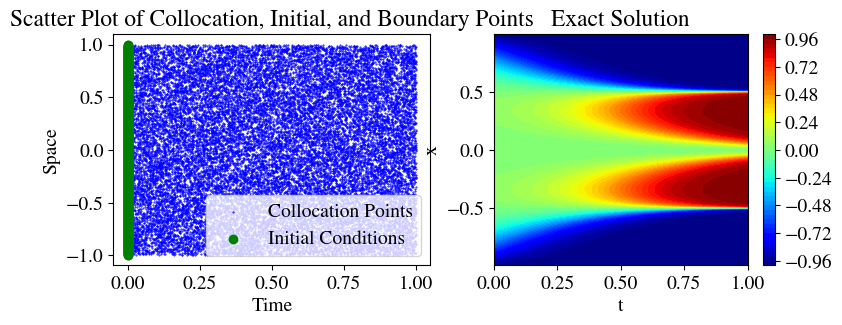

In [15]:
# Plotting code
fig = plt.figure(figsize=(9, 3))

# Scatter plot for collocation, initial, and boundary points
ax1 = fig.add_subplot(121)
ax1.scatter(tc, xc, color='blue', label='Collocation Points',s=0.2)
ax1.scatter(ti, xi, color='green', label='Initial Conditions')
ax1.set_xlabel('Time')
ax1.set_ylabel('Space')
ax1.set_title('Scatter Plot of Collocation, Initial, and Boundary Points')
ax1.legend()

# Surface plot for Exact solution
ax2 = fig.add_subplot(122)
contour = ax2.contourf(T, X, Exact0, cmap='jet', levels=50)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax2.set_xlabel('t')
ax2.set_ylabel('x')
ax2.set_title('Exact Solution')
plt.show()

## Initialize Model

In [16]:

# force jax to use one device
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

# feature sizes
feat_sizes = tuple([HIDDEN for _ in range(N_LAYERS)] + [FEATURES])
print(feat_sizes)
# make & init model
model = PINN(degree,degree_T,feat_sizes)
params = model.init(subkey, jnp.ones((NC, 1)), jnp.ones((NC, 1)))

optimizers = {
    'RBF_KAN_layer_0': optax.adam(optax.exponential_decay(lr0*args.lr_fact, decay_step, decay_rate, staircase=False)),
    'get_Psi': optax.adam(optax.exponential_decay(lr0, decay_step, decay_rate, staircase=False)),
}

# Initialize optimizer states for each parameter group
states = {key: optim.init(params['params'][key]) for key, optim in optimizers.items()}

# forward & loss function
apply_fn = jax.jit(model.apply)


total_params = sum(x.size for x in jax.tree_util.tree_leaves(params))
print(total_params )

(32, 32, 32, 32, 64)


19572


In [17]:
all_errors = []
all_its = []
all_loss = []
all_gamma = []
all_lamB = []
all_max_RBA = []

all_lamE = []
all_lambdas=[]
all_idx=[]
start = time.time()
pbar = tqdm(range(1, EPOCHS + 1), desc='Training Progress')
gamma_it=get_gamma(eta, max_RBA0)
#Global weights
max_RBA=max_RBA0
lamE,lamB=1,max_RBA**2
#RBA
step_RBA=(cap_RBA-max_RBA0)/(EPOCHS/50000-1)
# initialize grads container
all_grads={
    'grad_bar_PDE':1,
    'grad_bar_BCs':1,
}
for e in pbar:
    # sample batch 
    idx_train,_=sample_points_pdf(e, batch_size, lambdas, k=0, c=1.0) 
    # single run
    all_loss_it, gradient, lambdas,lamB,all_grads = apply_model(apply_fn, params, lambdas,gamma_it,eta,lamE,lamB,all_grads,idx_train, *train_data)

    for key in params['params']:
        params, states[key] = update_model(key, optimizers[key], gradient, params, states[key])
    log_frequency = 1 if e < 500 else 100 if e <= 5000 else 500
    if e % log_frequency == 0:
        # Update RBA
        max_RBA=max_RBA0+step_RBA*e//50000
        gamma_it=get_gamma(eta, max_RBA)
        all_lambdas.append(np.array(lambdas))  # JAX to NumPy conversion
        all_idx.append(idx_train)
        #Compute errors
        error = relative_l2(apply_fn(params, t, x), u_gt)
        # Updating the tqdm progress bar with loss and other metrics
        pbar.set_description(f"It: {e}/{EPOCHS} | Error: {error:.3e} | lam_max: {lambdas.max():.3f}| max_RBA: {max_RBA:.3f}| lamB: {lamB:.3f}")
        # Log metrics to TensorBoard
        with writer.as_default():
            tf.summary.scalar('Error', error, step=e)
            tf.summary.scalar('lam_max', lambdas.max(), step=e)
            tf.summary.scalar('max_RBA', max_RBA, step=e)
            tf.summary.scalar('lamB', lamB, step=e)
            tf.summary.scalar('gamma_it', gamma_it, step=e)    
            for key in all_loss_it.keys():
                tf.summary.scalar(key, all_loss_it[key], step=e)   
            for key in all_grads.keys():
                tf.summary.scalar(key, all_grads[key], step=e)          
        # Append metrics to lists
        all_errors.append(error)
        all_its.append(e)
        all_lambdas.append(np.array(lambdas))
        all_loss.append(all_loss_it['Loss'])
        all_gamma.append(gamma_it)
        all_lamB.append(lamB)
        all_max_RBA.append(max_RBA)

        all_lamE.append(lamE)
end = time.time()
print(f'Runtime: {((end - start) / EPOCHS * 1000):.2f} ms/iter.')

Training Progress:   0%|          | 0/300000 [00:00<?, ?it/s]

2025-01-16 12:39:04.946135: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce-window.2 = f32[800,32]{0,1} reduce-window(f32[800,32]{0,1} %broadcast.94, f32[] %constant.13), window={size=1x32 pad=0_0x31_0}, to_apply=%region_2.54

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-01-16 12:39:05.918284: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.972279355s
Constant folding an instruction is taking > 1s:

  %reduce-window.2 = f32[800,32]{0,1} reduce-window(f32[800,32]{0,1} %broadcast.94, f32[] %constant.13), window={size=1x32 pad=0_0x31_0}, to_a

Runtime: 7.88 ms/iter.


# Save Results

In [18]:
results_dict = {
    'model_name': args.Name,
    'all_errors': all_errors,
    'all_its': all_its,
    'all_loss': all_loss,
    'all_gamma': all_gamma,
    'all_lamB': all_lamB,
    'all_max_RBA': all_max_RBA,
}

# Save dictionary as a .mat file
scipy.io.savemat(args.Name + 'Log_files.mat', results_dict)

# Errors


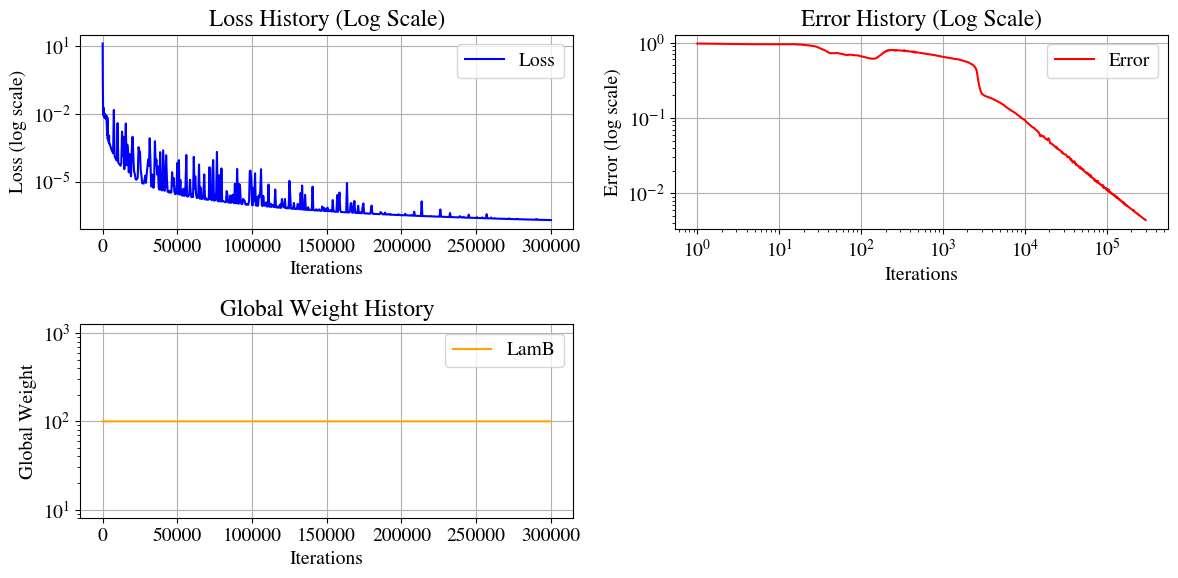

In [19]:
# Adjusting the plot to use a log scale for both loss and error

plt.figure(figsize=(12, 6))

# Plotting loss history with log scale
plt.subplot(2, 2, 1)
plt.plot(all_its, all_loss, label='Loss', color='blue')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Loss (log scale)')
plt.title('Loss History (Log Scale)')
plt.grid(True)
plt.legend()

# Plotting error history with log scale
plt.subplot(2, 2, 2)
plt.plot(all_its, all_errors, label='Error', color='red')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Error (log scale)')
plt.title('Error History (Log Scale)')
plt.grid(True)
plt.legend()

# Plotting error history with log scale
plt.subplot(2, 2, 3)
plt.plot(all_its, all_lamB, label='LamB', color='orange')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Global Weight')
plt.title('Global Weight History')
plt.grid(True)
plt.legend()



# Show the plots
plt.tight_layout()
plt.savefig(args.Name+'_Loss.png')
plt.show()


In [20]:
error = relative_l2(apply_fn(params, t, x), u_gt)
print(f'RL2 error: {error:.8f}') 

RL2 error: 0.00440907


Solution:


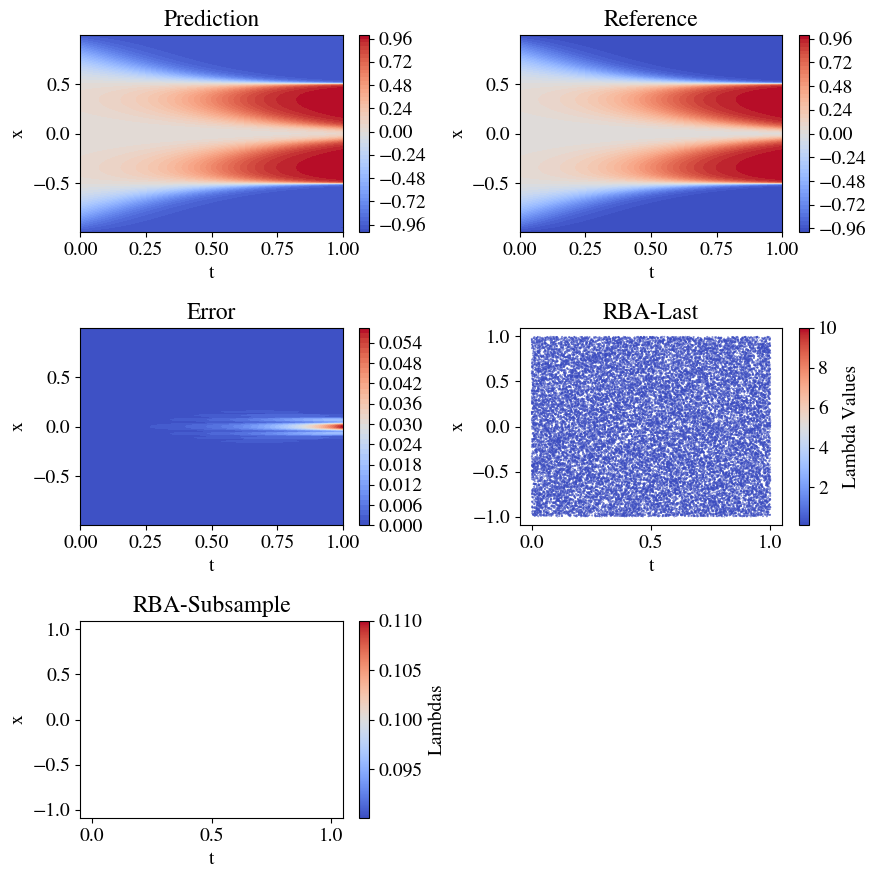

In [21]:
it=-1
print('Solution:')
u = apply_fn(params, t, x)
u = u.reshape(T.shape)
lambdas_grid=all_lambdas[it]
idx_it=all_idx[it]

# Plotting code
fig = plt.figure(figsize=(9, 9))
levels=50
# Scatter plot for collocation, initial, and boundary points
ax1 = fig.add_subplot(321)
contour = ax1.contourf(T, X, u, cmap='coolwarm', levels=levels)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax1.set_xlabel('t')
ax1.set_ylabel('x')
ax1.set_title('Prediction')

# Surface plot for Exact solution
ax2 = fig.add_subplot(322)
contour = ax2.contourf(T, X, Exact0, cmap='coolwarm', levels=levels)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax2.set_xlabel('t')
ax2.set_ylabel('x')
ax2.set_title('Reference')
# Surface plot for Exact solution
ax3 = fig.add_subplot(323)
contour = ax3.contourf(T, X, np.abs(Exact0-u), cmap='coolwarm', levels=levels)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax3.set_xlabel('t')
ax3.set_ylabel('x')
ax3.set_title('Error')
ax4 = fig.add_subplot(324)
scatter = ax4.scatter(tc, xc, c=lambdas_grid, cmap='coolwarm',vmax=10, s=0.1)
cbar = fig.colorbar(scatter, ax=ax4)
cbar.set_label('Lambda Values')
ax4.set_xlabel('t')
ax4.set_ylabel('x')
ax4.set_title('RBA-Last')
size_scale = 3  # Adjust this value to control the scaling of the point sizes
point_sizes = size_scale * (lambdas_grid[idx_it] - lambdas_grid[idx_it].min()) / (lambdas_grid[idx_it].max() - lambdas_grid[idx_it].min() + 1e-10)
ax4 = fig.add_subplot(325)
scatter = ax4.scatter(tc[idx_it], xc[idx_it], c=lambdas_grid[idx_it], cmap='coolwarm', s=point_sizes)
cbar = fig.colorbar(scatter, ax=ax4)
cbar.set_label('Lambdas')
ax4.set_xlabel('t')
ax4.set_ylabel('x')
ax4.set_title('RBA-Subsample')
plt.savefig(args.Name+'_Results.png')
plt.tight_layout()
plt.show()

Solution:


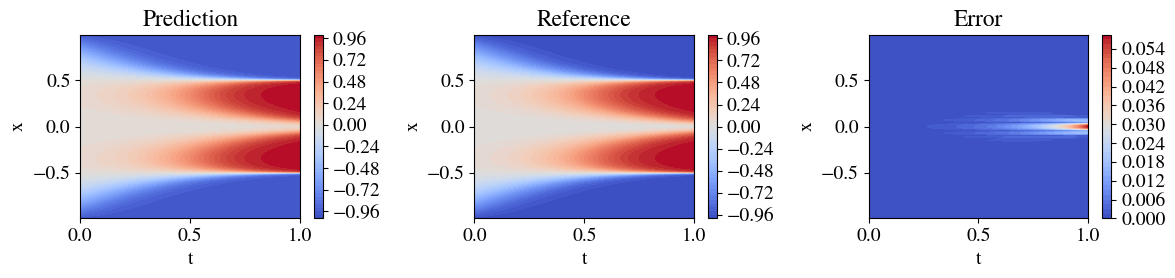

In [22]:
it=-1
print('Solution:')
u = apply_fn(params, t, x)
u = u.reshape(T.shape)
lambdas_grid=all_lambdas[it]
idx_it=all_idx[it]

# Plotting code
fig = plt.figure(figsize=(12, 3))
levels=50
# Scatter plot for collocation, initial, and boundary points
ax1 = fig.add_subplot(131)
contour = ax1.contourf(T, X, u, cmap='coolwarm', levels=levels)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax1.set_xlabel('t')
ax1.set_ylabel('x')
ax1.set_title('Prediction')

# Surface plot for Exact solution
ax2 = fig.add_subplot(132)
contour = ax2.contourf(T, X, Exact0, cmap='coolwarm', levels=levels)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax2.set_xlabel('t')
ax2.set_ylabel('x')
ax2.set_title('Reference')
# Surface plot for Exact solution
ax3 = fig.add_subplot(133)
contour = ax3.contourf(T, X, np.abs(Exact0-u), cmap='coolwarm', levels=levels)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax3.set_xlabel('t')
ax3.set_ylabel('x')
ax3.set_title('Error')
# ax4 = fig.add_subplot(224)
# scatter = ax4.scatter(tc, xc, c=lambdas_grid, cmap='coolwarm',vmax=10, s=0.1)
# cbar = fig.colorbar(scatter, ax=ax4)
# cbar.set_label('Lambda Values')
# ax4.set_xlabel('t')
# ax4.set_ylabel('x')
# ax4.set_title('RBA-Last')
# size_scale = 4  # Adjust this value to control the scaling of the point sizes
# point_sizes = size_scale * (lambdas_grid[idx_it] - lambdas_grid[idx_it].min()) / (lambdas_grid[idx_it].max() - lambdas_grid[idx_it].min() + 1e-10)
# ax4 = fig.add_subplot(224)
# scatter = ax4.scatter(tc[idx_it], xc[idx_it], c=lambdas_grid[idx_it], cmap='coolwarm', s=point_sizes)
# cbar = fig.colorbar(scatter, ax=ax4)
# cbar.set_label('Lambdas')
# ax4.set_xlabel('t')
# ax4.set_ylabel('x')
# ax4.set_title('RBA-Subsample')
plt.savefig(args.Name+'Errorss_RBA-R.png')
plt.tight_layout()
plt.show()

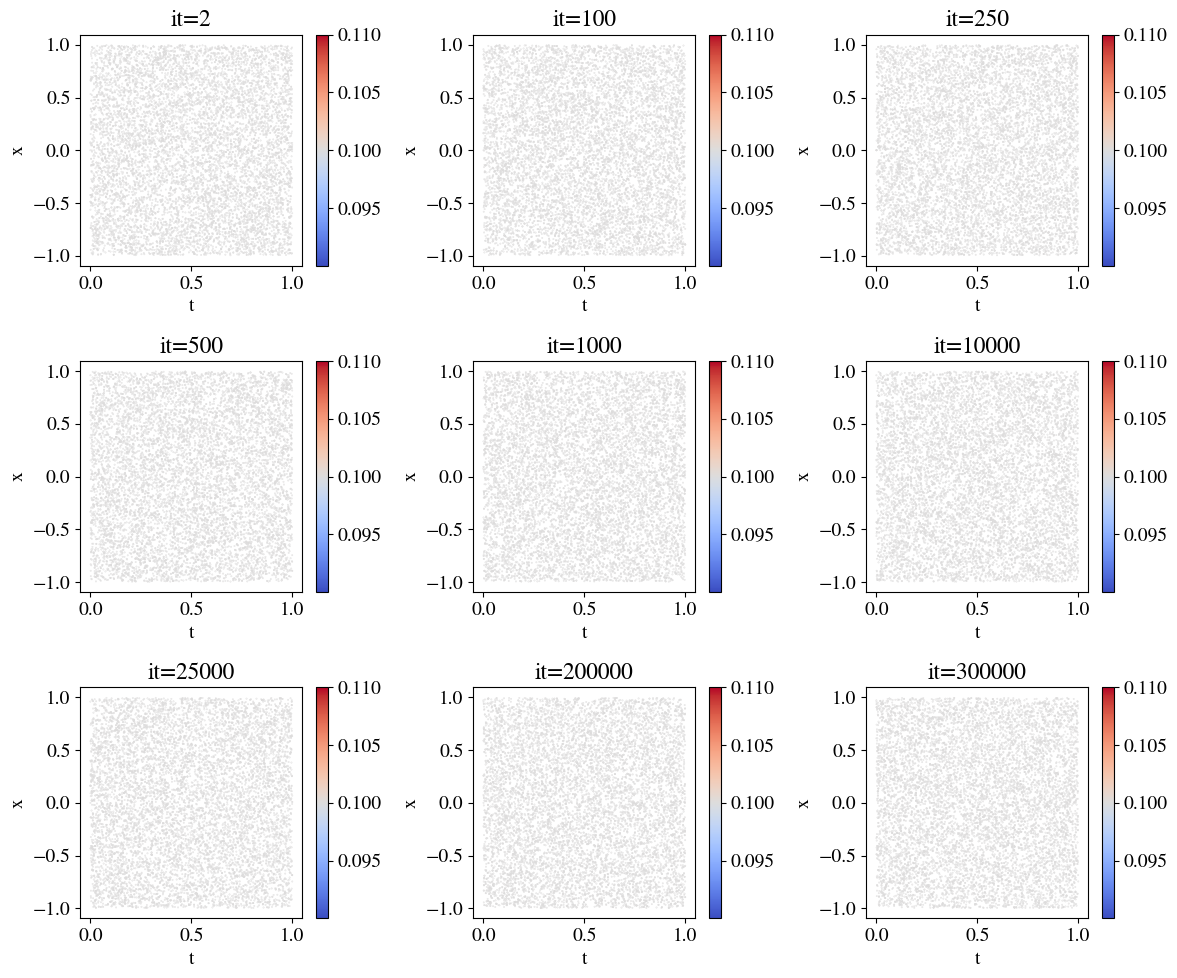

In [23]:
# Plotting code
fig = plt.figure(figsize=(12, 10))
size_scale = 2  # Adjust this value to control the scaling of the point sizes
base_size = 0.1   # Minimum size for points
it_list = [2, 100, 250, 500, 1000, 10000, 25000, 200000, 300000]
all_its_array = np.array(all_its)

for i, it in enumerate(it_list):
    # Find the index corresponding to the current iteration
    it_idx = np.argwhere(all_its_array.flatten() == it).flatten()[0]
    # Extract data for the current iteration
    lambdas_grid = all_lambdas[it_idx]
    idx_it = all_idx[it_idx]

    # Add subplot using corrected indexing
    subplot_index = i + 1  # Ensure subplot index starts at 1
    ax4 = fig.add_subplot(3, 3, subplot_index)

    # Calculate point sizes with base size
    point_sizes = base_size + size_scale * (lambdas_grid[idx_it] - lambdas_grid[idx_it].min()) / \
                  (lambdas_grid[idx_it].max() - lambdas_grid[idx_it].min() + 1e-10)

    # Create scatter plot
    scatter = ax4.scatter(tc[idx_it], xc[idx_it], c=lambdas_grid[idx_it], cmap='coolwarm', s=point_sizes)

    # Add colorbar
    cbar = fig.colorbar(scatter, ax=ax4)

    # Set axis labels and title
    ax4.set_xlabel('t')
    ax4.set_ylabel('x')
    ax4.set_title(f'it={it}')

# Save and display the plot
plt.tight_layout()
plt.savefig(args.Name + f'_Results_RBA-R.png')
plt.show()
